In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')


In [63]:
train = pd.read_csv('./Data/train.csv')
test = pd.read_csv('./Data/val.csv')

In [64]:
train.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2793718,2,2016-06-08 07:36:19,1,-73.985611,40.735943,-73.980331,40.760468,N,1040
1,id3485529,2,2016-04-03 12:58:11,1,-73.978394,40.764351,-73.991623,40.749859,N,827
2,id1816614,2,2016-06-05 02:49:13,5,-73.989059,40.744389,-73.973381,40.748692,N,614
3,id1050851,2,2016-05-05 17:18:27,2,-73.990326,40.731136,-73.991264,40.748917,N,867
4,id0140657,1,2016-05-12 17:43:38,4,-73.789497,40.646675,-73.987137,40.759232,N,4967


In [65]:
test.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2542907,1,2016-01-10 16:01:46,1,-74.013916,40.713444,-73.993858,40.752510,N,1249
1,id1709406,1,2016-06-23 18:41:05,1,-74.005440,40.727306,-73.983063,40.734715,N,817
2,id0983698,1,2016-05-14 21:25:34,1,-73.987587,40.749863,-73.986809,40.757549,N,366
3,id3045153,2,2016-05-02 20:09:00,1,-73.973862,40.784153,-73.983025,40.774479,N,195
4,id2383875,1,2016-05-19 10:01:39,1,-73.999916,40.733101,-74.008331,40.734177,N,283


In [66]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 10 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1000000 non-null  object 
 1   vendor_id           1000000 non-null  int64  
 2   pickup_datetime     1000000 non-null  object 
 3   passenger_count     1000000 non-null  int64  
 4   pickup_longitude    1000000 non-null  float64
 5   pickup_latitude     1000000 non-null  float64
 6   dropoff_longitude   1000000 non-null  float64
 7   dropoff_latitude    1000000 non-null  float64
 8   store_and_fwd_flag  1000000 non-null  object 
 9   trip_duration       1000000 non-null  int64  
dtypes: float64(4), int64(3), object(3)
memory usage: 76.3+ MB


In [67]:
print('Checking for missing data in train:')
print('Missing values found:',train.isna().sum().sum())
print('-'*30)
print('Checking for missing data in test:')
print('Missing values found:',test.isna().sum().sum())

Checking for missing data in train:
Missing values found: 0
------------------------------
Checking for missing data in test:
Missing values found: 0


In [68]:
train.describe(include = 'all')

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
count,1000000,1000000.000000,1000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000,1.000000e+06
unique,1000000,NaN,962731,NaN,NaN,NaN,NaN,NaN,2,NaN
top,id2793718,NaN,2016-04-05 18:55:21,NaN,NaN,NaN,NaN,NaN,N,NaN
freq,1,NaN,5,NaN,NaN,NaN,NaN,NaN,994443,NaN
mean,NaN,1.534793,NaN,1.665353,-73.973475,40.750947,-73.973421,40.751829,NaN,9.548850e+02
std,NaN,0.498788,NaN,1.315723,0.065404,0.033745,0.065432,0.035782,NaN,3.882070e+03
min,NaN,1.000000,NaN,0.000000,-121.933342,34.359695,-121.933304,34.359695,NaN,1.000000e+00
25%,NaN,1.000000,NaN,1.000000,-73.991852,40.737372,-73.991341,40.735928,NaN,3.970000e+02
50%,NaN,2.000000,NaN,1.000000,-73.981728,40.754131,-73.979767,40.754551,NaN,6.620000e+02
75%,NaN,2.000000,NaN,2.000000,-73.967346,40.768379,-73.963036,40.769833,NaN,1.074000e+03


- id column has all unique values for both train and test sets
- vendor_id has only 2 unique values (1 or 2) with a median of 2
- passenger_count has 9 unique values (0,1,2,3,4,5,6,7,8 or 9) with a median of 1
- store_and_fwd_flag has 2 unique values (Y or N)


# Feature Engineering


### Filter by Geographic Limits


In [69]:
def filter_geographical_boundaries(df, xlim, ylim):
    return df[
        (df.pickup_longitude > xlim[0]) & (df.pickup_longitude < xlim[1]) & 
        (df.dropoff_longitude > xlim[0]) & (df.dropoff_longitude < xlim[1]) &
        (df.pickup_latitude > ylim[0]) & (df.pickup_latitude < ylim[1]) & 
        (df.dropoff_latitude > ylim[0]) & (df.dropoff_latitude < ylim[1])
    ]

# Define geographical boundaries
xlim = [-74.03, -73.77]
ylim = [40.63, 40.85]

# Apply geographical boundary filtering
train = filter_geographical_boundaries(train, xlim, ylim)
test = filter_geographical_boundaries(test, xlim, ylim)

#### We have latitudes and longitudes which we cannot use directly in modeling. So I am going to experiment those into clusters.


In [70]:
from sklearn.cluster import KMeans


def apply_clustering(df, n_clusters=5):
    pickup_coordinates = df[['pickup_latitude', 'pickup_longitude']]
    dropoff_coordinates = df[['dropoff_latitude', 'dropoff_longitude']]

    pickup_kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    df['pickup_cluster_label'] = pickup_kmeans.fit_predict(pickup_coordinates)

    dropoff_kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    df['dropoff_cluster_label'] = dropoff_kmeans.fit_predict(dropoff_coordinates)
    
    return df

train=apply_clustering(train)
test=apply_clustering(test)

- Filtering the test set in the same manner as the training set can ensure that the model is evaluated on a similar distribution of data. This can be important in cases where the model is expected to work within certain geographical boundaries, such as a taxi service operating within a specific city area.


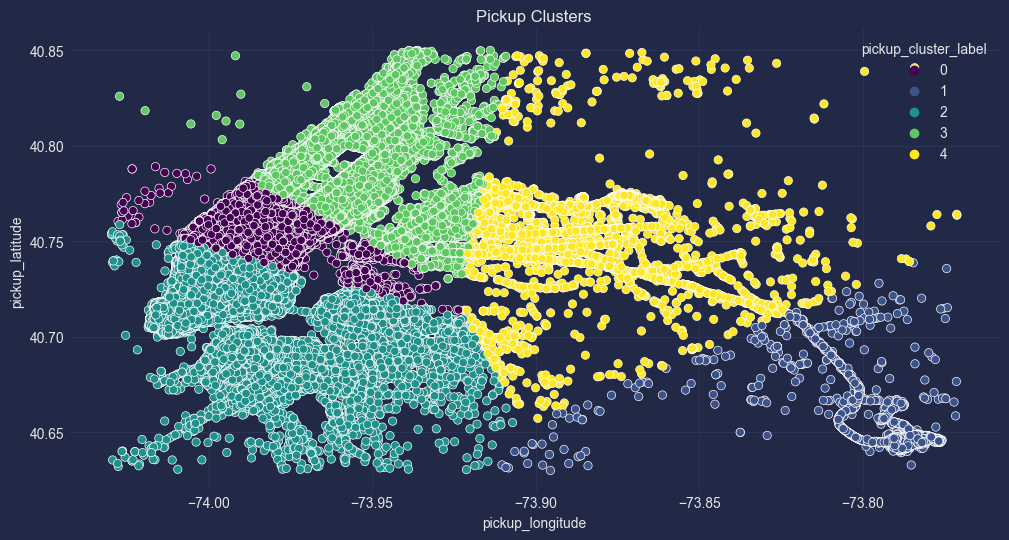

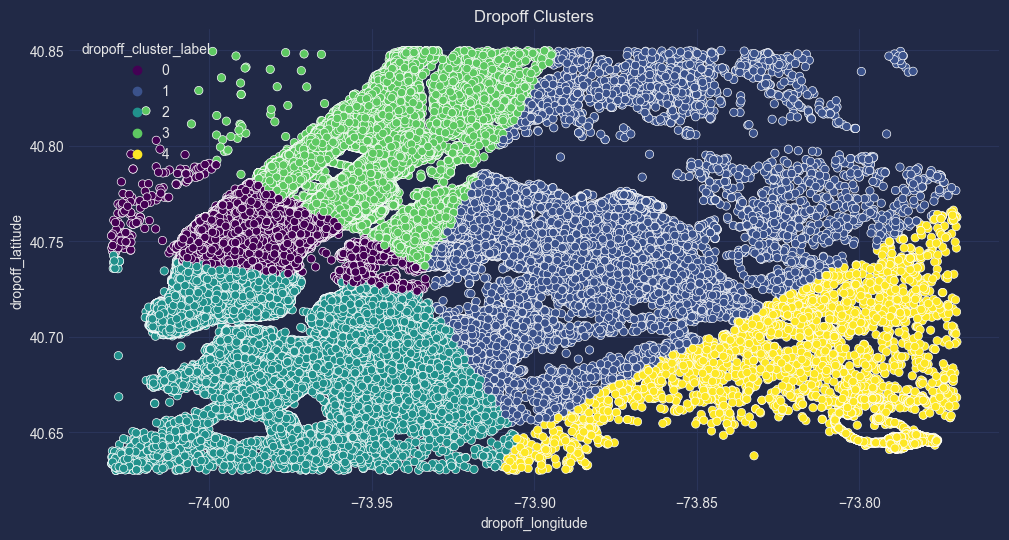

In [71]:
def visualize_clusters(df):
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x='pickup_longitude', y='pickup_latitude', hue='pickup_cluster_label', data=df, palette='rocket')
    plt.title('Pickup Clusters')
    plt.show()

    plt.figure(figsize=(12, 6))
    sns.scatterplot(x='dropoff_longitude', y='dropoff_latitude', hue='dropoff_cluster_label', data=df, palette='rocket')
    plt.title('Dropoff Clusters')
    plt.show()

visualize_clusters(train)

In [88]:
def haversine(lon1, lat1, lon2, lat2):
    from math import radians, cos, sin, asin, sqrt
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    km = 6371 * c
    return km

train['trip_distance'] = train.apply(lambda row: haversine(row['pickup_longitude'], row['pickup_latitude'], row['dropoff_longitude'], row['dropoff_latitude']), axis=1)
test['trip_distance'] = test.apply(lambda row: haversine(row['pickup_longitude'], row['pickup_latitude'], row['dropoff_longitude'], row['dropoff_latitude']), axis=1)


## Time


In [72]:
# train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'])
# test['pickup_datetime'] = pd.to_datetime(test['pickup_datetime'])

In [73]:
# Extracting additional info from date
def extract_datetime_features(df):
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
    df['pickup_year'] = df['pickup_datetime'].dt.year
    df['pickup_month'] = df['pickup_datetime'].dt.month
    df['pickup_day'] = df['pickup_datetime'].dt.dayofweek
    df['weekday'] = df['pickup_datetime'].dt.weekday
    df['pickup_time'] = df['pickup_datetime'].dt.hour
    df['trip_duration_minutes'] = df['trip_duration'] / 60
    df['season'] = df['pickup_datetime'].dt.month % 12 // 3 + 1
    df['pickup_date'] = pd.to_datetime(df['pickup_datetime'].dt.date)
    return df

train = extract_datetime_features(train)
test = extract_datetime_features(test)

## Remove Outliers


In [82]:
max_date = train['trip_duration_minutes'].idxmax()

print(f"Date of Maximum Average Trip Duration in average trip duration: {max_date}")

Date of Maximum Average Trip Duration in average trip duration: 9588


In [83]:
train['trip_duration_minutes'].describe()

count    937099.000000
mean         12.037714
std           7.311236
min           0.016667
25%           6.366667
50%          10.433333
75%          16.283333
max          34.233333
Name: trip_duration_minutes, dtype: float64

In [84]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

In [85]:
train = remove_outliers(train, 'trip_duration_minutes')

##### check train and test overlap - to make sure that we are really training on features that are relevant to our test data set


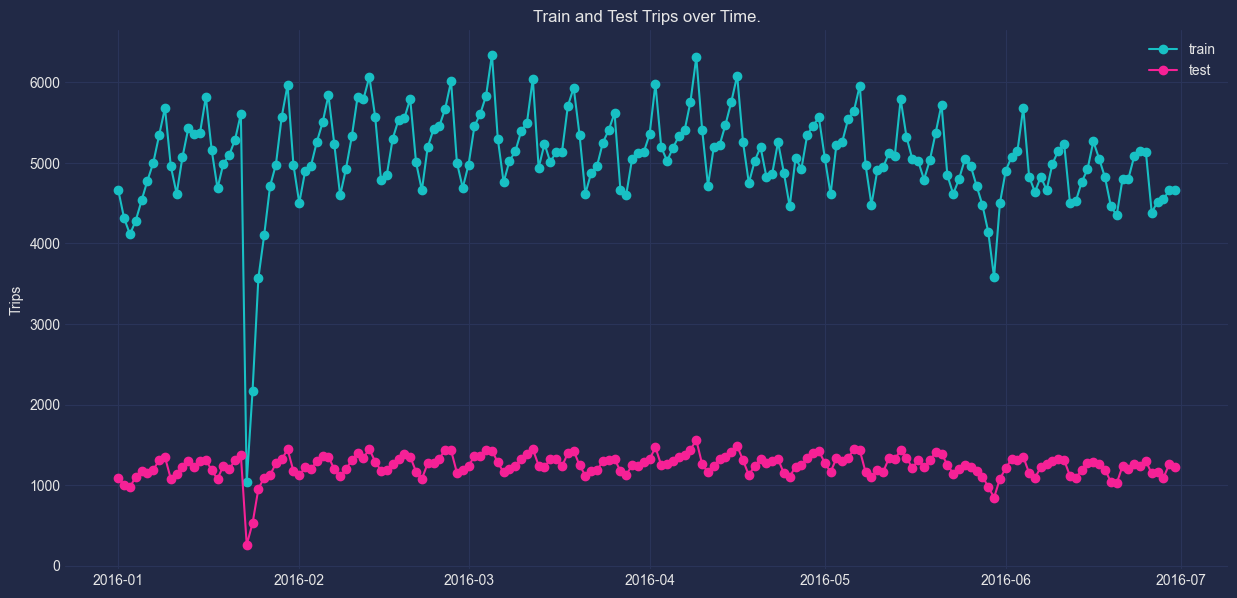

In [86]:
def check_train_test_overlap(train, test):
    fig, ax1 = plt.subplots(1, 1, figsize=(15, 7))
    plt.plot(train.groupby('pickup_date').count()[['vendor_id']], 'o-', label='train')
    plt.plot(test.groupby('pickup_date').count()[['vendor_id']], 'o-', label='test')
    ax1.set_title('Train and Test Trips over Time.')
    ax1.legend(loc=0)
    ax1.set_ylabel('Trips')
    plt.show()

check_train_test_overlap(train, test)

In [87]:
train.dropna(inplace=True)
test.dropna(inplace=True)